In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv
/kaggle/input/dogs-vs-cats/test1.zip


In [2]:
import os, shutil,zipfile
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zip:
    zip.extractall()    
    zip.close()

In [3]:
from keras import layers
from keras import models
from keras import optimizers
from keras.applications import InceptionResNetV2
from keras.preprocessing import image
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import Input

Using TensorFlow backend.


We are spliting dataset on smaller train,validation and test set

In [4]:
#this block is an quotation from the Deep Learning With Python(françois chollet) book.

# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '/kaggle/working/train'

# The directory where we will
# store our smaller dataset
base_dir = '/kaggle/working/cats_and_dogs_small'
os.mkdir(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# Copy first 2500 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(2500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 1000 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(2500, 3500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 1500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(3500, 5000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 2500 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(2500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 1000 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(2500, 3500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 1500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(3500, 5000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [5]:
size = (172,172,3) #resized images size
batch_size = 160 

Implementing data generator. We are using data augmentation on train test.

In [6]:
#data augmentation and normalize images with using ImageDataGenerator
train_datagen = image.ImageDataGenerator(rescale=1./255,
                                         rotation_range=40,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         fill_mode="nearest")

valid_datagen = image.ImageDataGenerator(rescale=1./255)

test_datagen = image.ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory("/kaggle/working/cats_and_dogs_small/train",
                                                    target_size=(172,172),
                                                    batch_size=batch_size,class_mode="binary")
validation_generator = valid_datagen.flow_from_directory("/kaggle/working/cats_and_dogs_small/validation",
                                                        target_size=(172,172),
                                                         batch_size=batch_size,class_mode="binary")
test_generator = test_datagen.flow_from_directory("/kaggle/working/cats_and_dogs_small/test",
                                                        target_size=(172,172),
                                                  batch_size=batch_size,class_mode="binary")

Found 5000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.


# Feature Extraction

Step 1 - Load pre-trained model and freeze

Step 2 - Create new model and add the frozen pretrained model in this model

Step 3 - Add dense layers

Step 4 - Train Model

In [8]:
input_tensor = Input(shape=size)
resnet = InceptionResNetV2(weights="imagenet",include_top=False,
                           input_tensor=input_tensor) #load pretrained model

219062272/219055592 [==============================] - 5s 0us/step


# Load Pre-trained Model

* We are select include_top = False. Because we are don't want dense layers.

* This Model coming with trained weights on imagenet

In [9]:
#resnet.summary() 

In [10]:
for i in resnet.layers: #freeze pretrained model
    i.trainable = False 

In [11]:
#create new model and add pretrained model in this model
x = resnet.output
x = layers.GlobalMaxPooling2D(data_format='channels_last')(x)
x = layers.Dropout(0.30)(x)
x = layers.Dense(256,activation="relu")(x)
x = layers.Dropout(0.30)(x)
x = layers.Dense(256,activation="relu")(x)
x = layers.Dense(1,activation="sigmoid")(x)
model = models.Model(resnet.input,x)

In [12]:
#model.summary()#now we have only 459,521 trainable params

In [13]:
model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["acc"])

In [14]:
history = model.fit_generator(train_generator,
                        steps_per_epoch=train_generator.samples//batch_size,epochs=12,
                        validation_data=validation_generator,
                        validation_steps=validation_generator.samples//batch_size)

Epoch 1/12
31/31 [==============================] - 69s 2s/step - loss: 1.1502 - acc: 0.6417 - val_loss: 0.1144 - val_acc: 0.9651
Epoch 2/12
31/31 [==============================] - 52s 2s/step - loss: 0.5316 - acc: 0.7192 - val_loss: 0.0708 - val_acc: 0.9630
Epoch 3/12
31/31 [==============================] - 51s 2s/step - loss: 0.4382 - acc: 0.8008 - val_loss: 0.1065 - val_acc: 0.9674
Epoch 4/12
31/31 [==============================] - 51s 2s/step - loss: 0.3947 - acc: 0.8054 - val_loss: 0.0615 - val_acc: 0.9696
Epoch 5/12
31/31 [==============================] - 49s 2s/step - loss: 0.3876 - acc: 0.8208 - val_loss: 0.1201 - val_acc: 0.9386
Epoch 6/12
31/31 [==============================] - 50s 2s/step - loss: 0.3637 - acc: 0.8345 - val_loss: 0.0944 - val_acc: 0.9658
Epoch 7/12
31/31 [==============================] - 49s 2s/step - loss: 0.3559 - acc: 0.8312 - val_loss: 0.1786 - val_acc: 0.9625
Epoch 8/12
31/31 [==============================] - 51s 2s/step - loss: 0.3196 - acc: 0.85

In [15]:
epochs = range(1,len(history.history["acc"])+1)

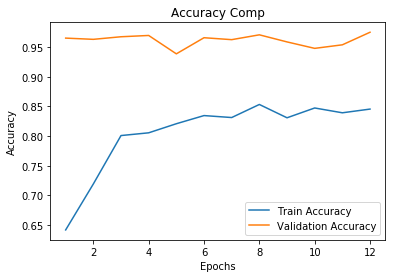

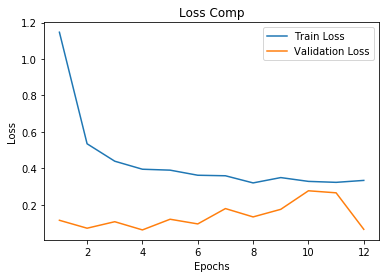

In [16]:
plt.plot(epochs,history.history["acc"],label="Train Accuracy")
plt.plot(epochs,history.history["val_acc"],label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Comp")
plt.legend()
plt.show()

plt.plot(epochs,history.history["loss"],label="Train Loss")
plt.plot(epochs,history.history["val_loss"],label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comp")
plt.legend()
plt.show()


In [17]:
loss,acc = model.evaluate_generator(generator=test_generator,
                                steps=test_generator.samples//batch_size)

In [18]:
print("Test Accuracy =",acc)

Test Accuracy = 0.9791666865348816


# Fine Tunning

Step 1 - Take the Feature Extraction(We are did this step)

Step 2 - Select layers to Fine Tunning

Step 3 - Train Model


In [19]:
liste = [x.name for x in model.layers]

In [20]:
#select after blocks block8_10_conv to fine tunnig
for i in range(liste.index("block8_10_conv"),len(model.layers)): 
    model.layers[i].trainable = True #unfreeze the layers

In [21]:
#compile model with very low learning rate
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.00005),
              loss="binary_crossentropy",metrics=["acc"])

In [22]:
#model.summary() #now we have 4,589,857 trainable params

In [23]:
history = model.fit_generator(train_generator,steps_per_epoch=train_generator.samples//batch_size,
                              epochs=15,validation_data=validation_generator,
                              validation_steps=validation_generator.samples//batch_size)

Epoch 1/15
31/31 [==============================] - 68s 2s/step - loss: 0.2540 - acc: 0.8868 - val_loss: 0.2689 - val_acc: 0.9734
Epoch 2/15
31/31 [==============================] - 52s 2s/step - loss: 0.2254 - acc: 0.9027 - val_loss: 0.1312 - val_acc: 0.9739
Epoch 3/15
31/31 [==============================] - 52s 2s/step - loss: 0.2162 - acc: 0.9093 - val_loss: 0.1374 - val_acc: 0.9793
Epoch 4/15
31/31 [==============================] - 52s 2s/step - loss: 0.2047 - acc: 0.9109 - val_loss: 0.0527 - val_acc: 0.9712
Epoch 5/15
31/31 [==============================] - 49s 2s/step - loss: 0.2020 - acc: 0.9142 - val_loss: 0.1287 - val_acc: 0.9755
Epoch 6/15
31/31 [==============================] - 50s 2s/step - loss: 0.1950 - acc: 0.9155 - val_loss: 0.1221 - val_acc: 0.9734
Epoch 7/15
31/31 [==============================] - 49s 2s/step - loss: 0.1856 - acc: 0.9197 - val_loss: 0.0705 - val_acc: 0.9745
Epoch 8/15
31/31 [==============================] - 51s 2s/step - loss: 0.1803 - acc: 0.92

In [24]:
epochs = range(1,len(history.history["acc"])+1)

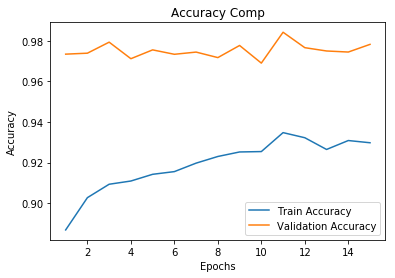

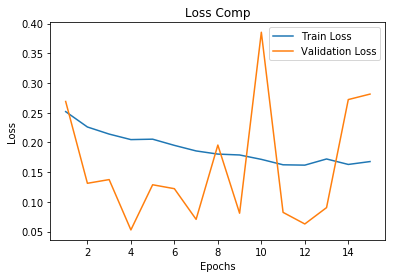

In [25]:
plt.plot(epochs,history.history["acc"],label="Train Accuracy")
plt.plot(epochs,history.history["val_acc"],label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Comp")
plt.legend()
plt.show()

plt.plot(epochs,history.history["loss"],label="Train Loss")
plt.plot(epochs,history.history["val_loss"],label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comp")
plt.legend()
plt.show()

In [26]:
loss,acc = model.evaluate_generator(generator=test_generator,
                                    steps=test_generator.samples//batch_size)

In [27]:
print("Test Accuracy =",acc)

Test Accuracy = 0.984375
